In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
#----------------------------------
# Mass appraisal functions
#----------------------------------

def weightedMean(pred, sp):
    '''
    Returns the weighted mean ratio
    
        Parameters:
            pred (pandas.Series): Series of predicted values
            sp   (pandas.Series): Series of sale prices
            
        Returns:
            weighted mean (numpy.float64): Weighted mean ratio
            
    '''
    return pred.sum() / sp.sum()

def averageDeviation(pred, sp):
    '''
    Returns the average deviation
    
        Parameters:
            pred (pandas.Series): Series of predicted values
            sp   (pandas.Series): Series of sale prices
            
        Returns:
            average deviation (numpy.float64): Average difference between each value
            
    '''
    medianRatio = (pred / sp).median()
    return ((pred / sp) - medianRatio).abs().sum() / len(sp) 

def COD(pred, sp):
    '''
    Returns the coefficient of dispersion
    
        Parameters:
            pred (pandas.Series): Series of predicted values
            sp   (pandas.Series): Series of sale prices
            
        Returns:
            coefficient of dispersion (numpy.float64): Average deviation as a percentage
            
    '''
    medianRatio = (pred / sp).median()
    return (100.00 * averageDeviation(pred, sp)) / medianRatio

def PRD(pred, sp):
    '''
    Returns the price related differential
    
        Parameters:
            pred (pandas.Series): Series of predicted values
            sp   (pandas.Series): Series of sale prices
            
        Returns:
            price related differential (numpy.float64): Statistic for measuring assessment regressivity
            
    '''
    meanRatio = (pred / sp).mean()
    return meanRatio / weightedMean(pred, sp)

def PRB(pred, sp):
    '''
    Returns the price related bias
    
        Parameters:
            pred (pandas.Series): Series of predicted values
            sp   (pandas.Series): Series of sale prices
            
        Returns:
            price related bias results (dict): Dictionary containing the PRB statistic and it's significance
            
    '''
    RATIO = pred / sp
    medianRatio = (RATIO).median()
    VALUE = (0.50 * sp) + (0.50 * pred / pred.median())
    LN_VALUE = np.log(VALUE) / np.log(2)
    PCT_DIFF = (RATIO - medianRatio) / medianRatio
    modelData = sm.add_constant(LN_VALUE)
    model = sm.OLS(PCT_DIFF, modelData).fit()
    return {"PRB" : model.params[0], "Sig" : model.pvalues[0]}



In [19]:
#------------------------------------
# Helper functions for this notebook
#------------------------------------

def plotResults(data, error_column):
    '''
    Creates plots showing COD, PRD, PRB against percentage of corrupted data 
    
        Parameters:
            data          (pandas.DataFrame): DataFrame of model values
            error_column  (string): Name of column that contains the corrupted data
            
        Returns:
            None
            
    '''
    for stat in ["COD", "PRD", "PRB"]:
        p = sns.lmplot(x='Percent Corrupted', y=stat, data = data, lowess = True, line_kws={'color': 'red'})
        p.fig.set_figwidth(15)
        p.fig.set_figheight(2)
        p.ax.set_title("Simulated %s with increasing data corruption of %s" % (stat, error_column))
        p.ax.ticklabel_format(useOffset=False)


def model_corrupted_data(data, model_formula, error_column, percent_corrupted, error_mean, error_sd, column_min_value, column_max_value):
    '''
    Captures statistics for a regression model after randomly adding errors to a given coefficient
    
        Parameters:
            data              (pandas.DataFrame): The modeling data
            model_formula     (string):           Regression fromula
            error_column      (string):           The coefficient that with recieve the errors
            percent_corrupted (float):            The percentage of the data to corrupt
            error_mean        (float):            The center for the error distribution
            error_sd          (float):            Spread of the generated errros
            column_min_value  (float):            Minimum error generated value (example: Building SQFT should be > 0)
            column_max_value  (float):            Maximum error generated value
            
            
        Returns:
            rv (pandas.DataFrame):  A dataframe containing the Percent Corrupted, COD, PRD, PRB for the regression model
                                    It is possible that given enough errors a solution for the regression is unable to be 
                                    found.  If no solution found the return value is None
            
        
            
    '''
    percent_corrupted = np.clip(percent_corrupted, .01, 1.0)
    df=data.copy()
    hasError = np.random.binomial(1, percent_corrupted, size=df.shape[0])
    error = np.random.normal(error_mean, error_sd, df.shape[0])
    df[error_column] = np.where(hasError == 1, np.clip(df[error_column] + error, column_min_value, column_max_value), df[error_column]) 
    try:
        regression = smf.ols(formula=model_formula, data=df).fit()
        sp = np.exp(regression.model.endog)
        pred = np.exp(regression.fittedvalues)
        prb = PRB(pred, sp)
        rv = pd.DataFrame({
            "Percent Corrupted" : [percent_corrupted],
            "COD" : [COD(pred, sp)],
            "PRD" : [PRD(pred, sp)],
            "PRB" : [prb['PRB'] if prb['Sig'] <= .05 else None]
        })
        rv.name = error_column 
        return rv
    except:
        return None           
        

In [4]:
# Load sample data
# Outliers have not been removed.
data = pd.read_csv('StandardsSampleData.csv')
data.head()

,SalesPrice,Sqft,LandSize,Age,Bathrooms,NBHD,GarageSize,NBHD_101,NBHD_102,NBHD_104,NBHD_105
0,154603,991,10175,40,2.0,101,0,1,0,0,0
1,150872,950,17823,67,2.0,101,264,1,0,0,0
2,179655,1573,13907,31,2.5,101,264,1,0,0,0
3,204465,1584,12351,48,2.5,101,0,1,0,0,0
4,218999,1471,15929,56,1.5,101,0,1,0,0,0


In [5]:
# check for zero values
data.apply(['min'])

,SalesPrice,Sqft,LandSize,Age,Bathrooms,NBHD,GarageSize,NBHD_101,NBHD_102,NBHD_104,NBHD_105
min,82564,900,10000,0,1.5,101,0,0,0,0,0


In [6]:
# set regression formula (multiplicative model). 
# note: as this is a log model any coefficient that might have a zero value needs to have 1 added to it when taking the log.
#       Nbhd_103 is the base nbhd
regressionFormula = "np.log(SalesPrice) ~ np.log(Sqft)+np.log(LandSize)+np.log(Age + 1)+np.log(Bathrooms)+np.log(GarageSize + 1)+NBHD_101+NBHD_102+NBHD_104+NBHD_105"

In [7]:
# Run the regression without errors and show the results.
result = smf.ols(formula=regressionFormula, data=data).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log(SalesPrice)   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                 1.561e+04
Date:                Thu, 26 Oct 2023   Prob (F-statistic):               0.00
Time:                        14:49:50   Log-Likelihood:                 5252.7
No. Observations:                8300   AIC:                        -1.049e+04
Df Residuals:                    8290   BIC:                        -1.042e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  5.6231      0.087     64.456      0.000       5.452       5.794
np.log(Sqft)               0.9021      0.008    111.088      0.000       0.886       0.918
np.log(LandSize)           0.0520      0.006      8.409      0.000       0.040       0.064
np.log(Age + 1)           -0.0661      0.002    -31.662      0.000      -0.070      -0.062
np.log(Bathrooms)          0.0749      0.008      8.852      0.000       0.058       0.092
np.log(GarageSize + 1)     0.0082      0.001     11.565      0.000       0.007       0.010
NBHD_101                  -0.2783      0.008    -34.966      0.000      -0.294      -0.263
NBHD_102                  -0.0141      0.006     -2.489      0.013      -0.025      -0.003
NBHD_104                   0.0890      0.006     14.505      0.000       0.077       0.101
NBHD_105                   0.1445      0.008     17.068      0.000       0.128       0.161
==============================================================================
Omnibus:                      200.155   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              218.903
Skew:                          -0.366   Prob(JB):                     2.92e-48
Kurtosis:                       3.313   Cond. No.                         854.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
# Display regression model statistics
print("Wgt Mean: %.4f" % weightedMean(np.exp(result.fittedvalues), np.exp(result.model.endog)))
print("COD: %.2f" % COD(np.exp(result.fittedvalues), np.exp(result.model.endog)))
print("PRD: %.2f" % PRD(np.exp(result.fittedvalues), np.exp(result.model.endog)))
prb = PRB(np.exp(result.fittedvalues), np.exp(result.model.endog))
print("PRB: %.2f" % prb['PRB'], " Significance: %.3f" % prb['Sig'])

mResults = data.copy()
mResults['PredictedValue'] = np.exp(result.fittedvalues).astype(int)
mResults['Ratio'] = mResults['PredictedValue'] / mResults['SalesPrice']

print("Mean Ratio: %.2f" % mResults['Ratio'].mean())
print("Max Ratio: %.2f" % mResults['Ratio'].max())
print("Min Ratio: %.2f" % mResults['Ratio'].min())

mResults.head()

Wgt Mean: 0.9923
COD: 10.37
PRD: 1.02
PRB: -0.04  Significance: 0.000
Mean Ratio: 1.01
Max Ratio: 1.96
Min Ratio: 0.68


,SalesPrice,Sqft,LandSize,Age,Bathrooms,NBHD,GarageSize,NBHD_101,NBHD_102,NBHD_104,NBHD_105,PredictedValue,Ratio
0,154603,991,10175,40,2.0,101,0,1,0,0,0,140625,0.909588
1,150872,950,17823,67,2.0,101,264,1,0,0,0,141065,0.934998
2,179655,1573,13907,31,2.5,101,264,1,0,0,0,234577,1.305708
3,204465,1584,12351,48,2.5,101,0,1,0,0,0,217926,1.065835
4,218999,1471,15929,56,1.5,101,0,1,0,0,0,196832,0.898780


<h3>At the time of uploading this file there is a warning produced by the seaborn package that will be corrected by a future release of the matplotlib package.</h3><p>
See <a href="https://github.com/mwaskom/seaborn/issues/3431">https://github.com/mwaskom/seaborn/issues/3431</a></p>
<p>To supress the warning message the following code can be used.</p>
<pre><code>import warnings
warnings.filterwarnings('ignore')</code></pre>


In [9]:
# Supress figure layout warning
import warnings
warnings.filterwarnings('ignore')

,Percent Corrupted,COD,PRD,PRB
0,0.01,10.415768,1.016474,-0.041605
1,0.02,10.459466,1.016630,-0.041813
2,0.03,10.530088,1.017230,-0.043263
3,0.04,10.616378,1.017464,-0.043944
4,0.05,10.697789,1.017751,-0.044677


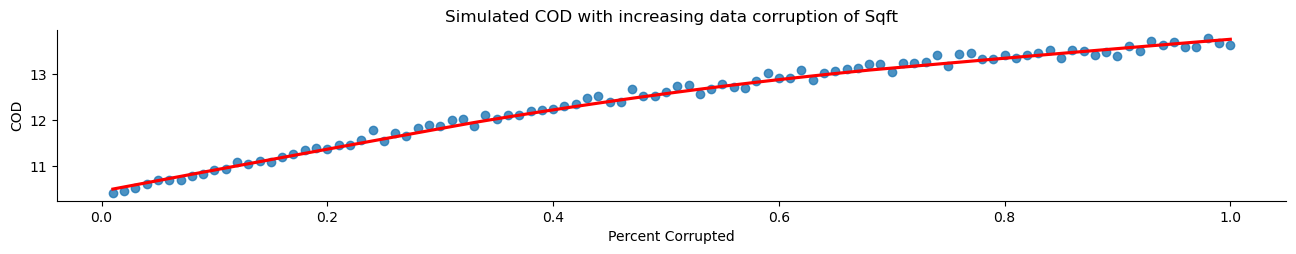

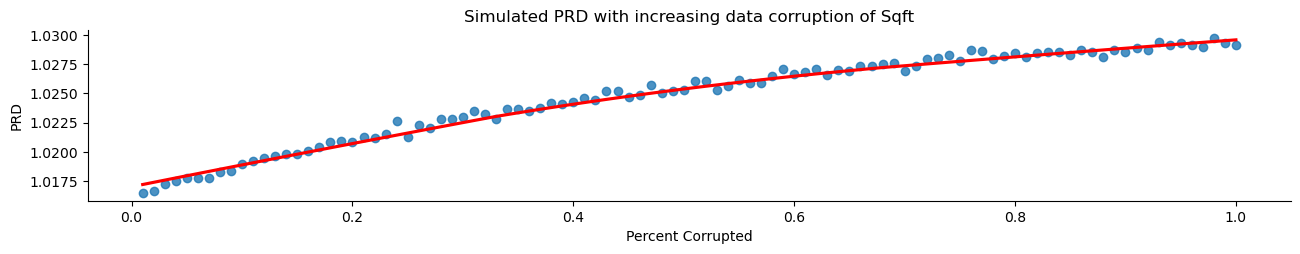

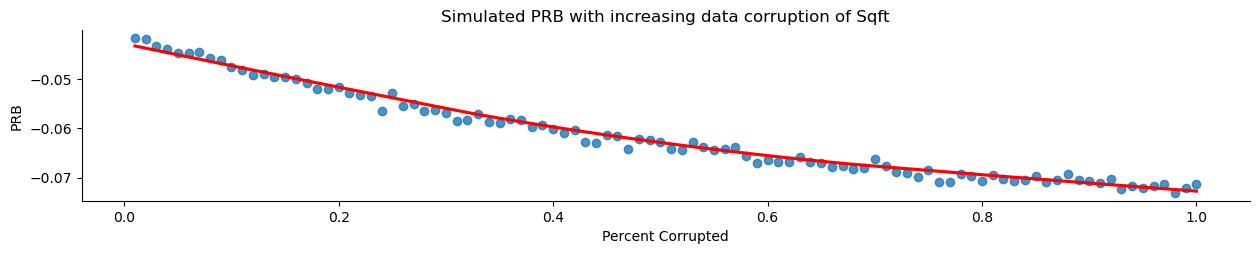

In [14]:
# Corrupt the Sqft coefficient from 1% to 100% and plot the results.
# Errors are centered around 0 with a standard deviation of 300sf and a minimum allowed corrupted sqft value of 500
results = pd.DataFrame(columns = ['Percent Corrupted', 'COD', 'PRD', 'PRB'])
for error_percent in np.arange(.01, 1.01, .01).round(2):
    x = model_corrupted_data(data, regressionFormula, 'Sqft', error_percent, 0, 300, 500, np.inf)
    if x is not None:
        if results.empty:
            results = x
        else:
            results = pd.concat([results, x], ignore_index = True)
plotResults(results, x.name)
results.head()

,Percent Corrupted,COD,PRD,PRB
0,0.01,10.369121,1.016219,-0.040898
1,0.02,10.373698,1.016245,-0.040949
2,0.03,10.372351,1.016244,-0.040904
3,0.04,10.379298,1.016255,-0.040993
4,0.05,10.398103,1.016308,-0.041088


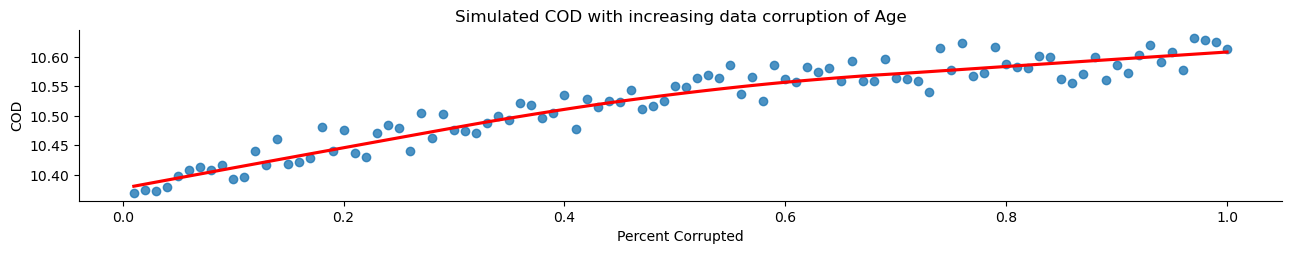

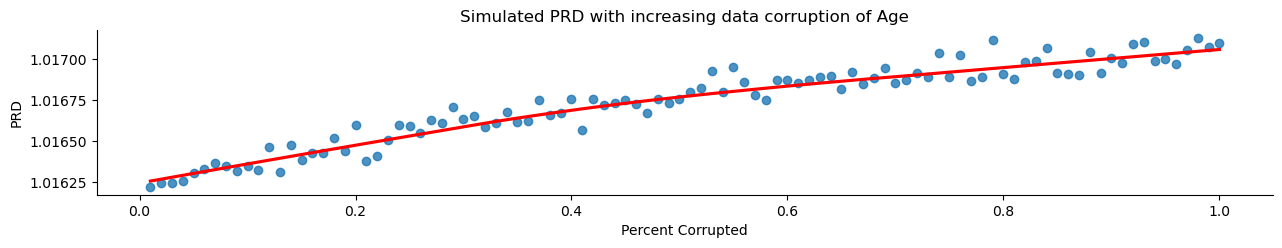

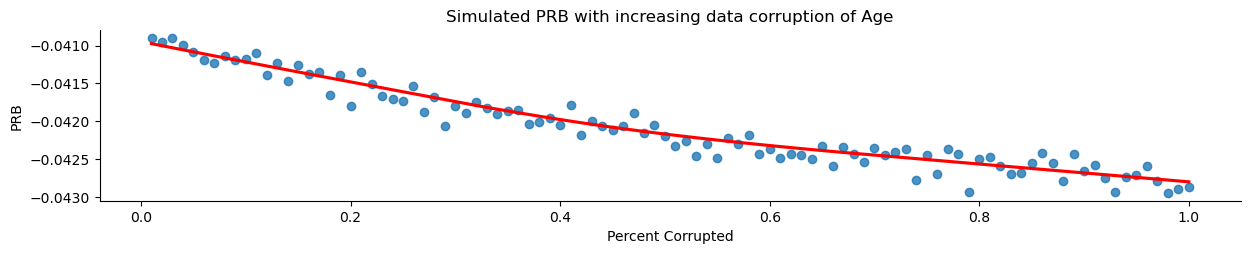

In [20]:
# Corrupt the Age coefficient from 1% to 100% and plot the results.
# Errors are centered around 0 with a standard deviation of 10 years and a minimum allowed corrupted Age value of 0
results = pd.DataFrame(columns = ['Percent Corrupted', 'COD', 'PRD', 'PRB'])
for error_percent in np.arange(.01, 1.01, .01).round(2):
    x = model_corrupted_data(data, regressionFormula, 'Age', error_percent, 0, 10, 0, np.inf)
    if x is not None:
        if results.empty:
            results = x
        else:
            results = pd.concat([results, x], ignore_index = True)
plotResults(results, x.name)
results.head()